# Машины опорных векторов (SVM)
SVM ищет разделяющую гиперплоскость с максимальным зазором: $\min_{w,b} \frac{1}{2}||w||^2$ при ограничениях $y_i (w^\top x_i + b) \ge 1$. Для мягкого зазора вводят штраф $C$ и переменные ошибок: $\min_{w,b,\xi} \frac{1}{2}||w||^2 + C\sum_i \xi_i$. Нелинейное разделение достигается через ядро $K(x,x')=\phi(x)^\top\phi(x')$ (например RBF). Предсказание: $\hat{y}=\mathrm{sign}(\sum_i \alpha_i y_i K(x_i, x) + b)$.


## Используемые библиотеки
Используем `numpy`, `pandas`, `seaborn`, `matplotlib`. Из `sklearn` — `load_digits`, `train_test_split`, `StandardScaler`, `Pipeline`, `SVC` и метрики классификации.


In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [20]:
sns.set_theme(style="whitegrid", palette="deep")
plt.rcParams["figure.dpi"] = 120
PRIMARY_COLOR = "#1f77b4"
HEATMAP_CMAP = "coolwarm"
CONFUSION_CMAP = "Blues"


## Датасет: описание и частичная распечатка
Датасет **Digits** из `sklearn` — 1797 изображений рукописных цифр (0–9) в виде матриц 8×8 пикселей (64 признака). Это задача мультиклассовой классификации (10 классов) с высокой размерностью признаков. Классы сбалансированы (~180 примеров каждый). SVM с RBF-ядром исторически являлся одним из лучших методов для распознавания рукописных цифр до эпохи глубокого обучения.


In [21]:
digits = load_digits(as_frame=True)
data = digits.frame
print(f"Размерность: {data.shape}")
data.head()


Размерность: (1797, 65)


,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


## Предварительная обработка
Разделяем признаки (64 пиксельных значения) и метку. Разбиваем на train/test со стратификацией. `StandardScaler` критически важен для SVM: ядро RBF вычисляет $||x - x'||^2$, и без нормировки признаки с большим диапазоном значений доминируют над остальными, что искажает геометрию пространства.


In [22]:
features = data.drop(columns=["target"])
target = data["target"]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target
)


## Тепловая карта корреляций
Берём подмножество из первых 12 пиксельных признаков для наглядности. Соседние пиксели на изображении коррелируют — пространственная структура данных отражается в тепловой карте. Полная матрица из 64 признаков была бы малочитаемой, но паттерн тот же.


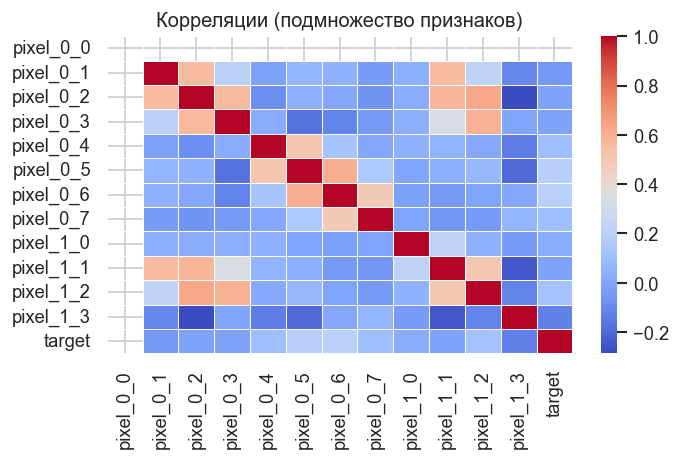

In [23]:
plt.figure(figsize=(6, 4))
subset_cols = features.columns[:12]
correlation = data[list(subset_cols) + ["target"]].corr()
sns.heatmap(correlation, annot=False, cmap=HEATMAP_CMAP, linewidths=0.3)
plt.title("Корреляции (подмножество признаков)")
plt.tight_layout()
plt.show()


## Обучение модели
`Pipeline` из `StandardScaler` и `SVC(kernel='rbf', gamma='scale')`. `gamma='scale'` устанавливает $\gamma = \frac{1}{n \cdot \mathrm{Var}(X)}$, что автоматически адаптируется к числу признаков. Параметр `C` по умолчанию = 1 (мягкий зазор). Для дальнейшей настройки рекомендуется `GridSearchCV` по $C \in [0.1, 10]$ и $\gamma$.


In [24]:
model = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("svm", SVC(kernel="rbf", gamma="scale")),
    ]
)
model.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()), ('svm', SVC())])

## Прогнозы модели
Метрики с усреднением `weighted` для 10 классов:
- **Accuracy** ≥ 0.98 — типичный результат для SVM+RBF на Digits;
- **Precision/Recall/F1** — показывают, какие цифры распознаются хуже (часто путают 1↔7, 3↔5, 4↔9).


In [25]:
y_pred = model.predict(X_test)

print("SVM Metrics")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.3f}")
print(f"Recall:    {recall_score(y_test, y_pred, average='weighted'):.3f}")
print(f"F1:        {f1_score(y_test, y_pred, average='weighted'):.3f}")


SVM Metrics
Accuracy:  0.975
Precision: 0.976
Recall:    0.975
F1:        0.975


## Графики выходных результатов
**График 1. Матрица ошибок 10×10.** Диагональ должна быть тёмно-синей. Ярко выделенные внедиагональные ячейки указывают на систематически путаемые пары цифр — визуально похожие символы.

**График 2. Точность по классам.** Почти все цифры должны распознаваться с точностью близкой к 1.0. Отклонения укажут, какие классы сложнее для SVM при данной конфигурации ядра.


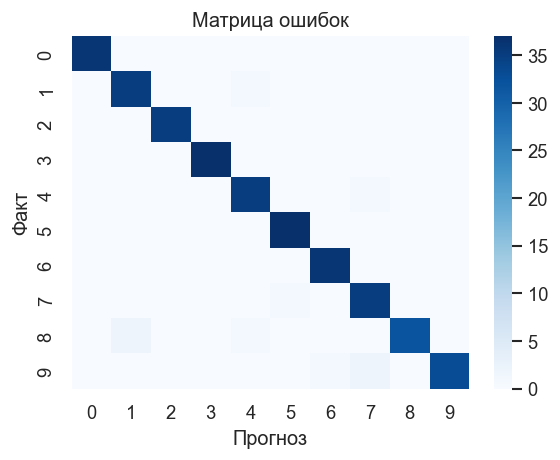

In [26]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=False, cmap=CONFUSION_CMAP)
plt.title("Матрица ошибок")
plt.xlabel("Прогноз")
plt.ylabel("Факт")
plt.tight_layout()
plt.show()


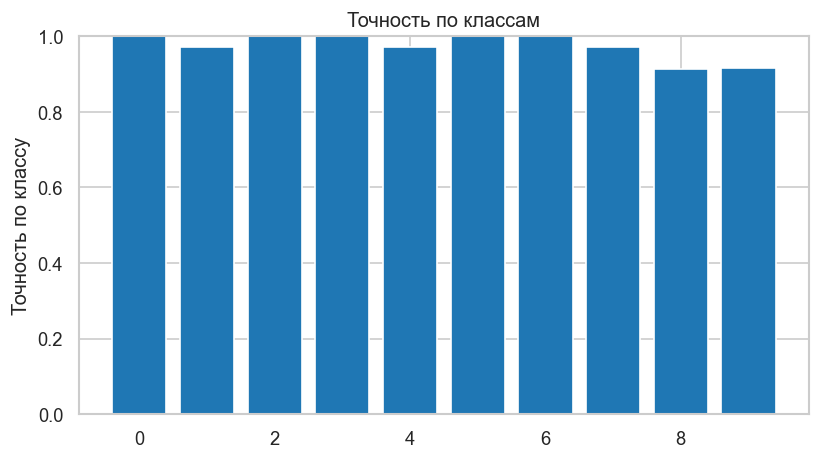

In [27]:
class_names = digits.target_names
per_class_acc = []
for cls in np.unique(y_test):
    mask = y_test == cls
    per_class_acc.append(np.mean(y_pred[mask] == y_test[mask]))

plt.figure(figsize=(7, 4))
plt.bar(class_names, per_class_acc, color=PRIMARY_COLOR)
plt.ylim(0, 1)
plt.ylabel("Точность по классу")
plt.title("Точность по классам")
plt.tight_layout()
plt.show()
